In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
from scipy.ndimage import gaussian_filter
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from math import floor

from data_cube import DataCube
from similarity_network_fusion import SNF, cumulated_euc_ts

In [3]:
import os

In [19]:
img_types = ["ssm", "iso", "snf"]
for img in img_types:
    for i in range(4):
        os.makedirs("./Data/"+img+"/"+str(i), exist_ok=True)

In [4]:
dc = DataCube(
    subjects="all",
    gestures=["3", "4", "5", "6"],
    channels=["2", "4", "6", "8"],
    data_grp="parsed")
dc.load_data()
dc.normalize_modalities()
dc.rms_smooth(100, 50)

dc.get_max_obs(smooth=True)

In [5]:
subj_lab = []
gest_lab = []
arrays = []

for s, gdict in dc.data_set_smooth.items():
    for g, a in gdict.items():
        subj_lab.append(s)
        gest_lab.append(int(g[0]))
        arrays.append(a[:, 1:-1])

In [15]:
# set to array and base at shift gestures down by 3 (i.e. to 0,1,2,3 instead of 3,4,5,6) for keras
gest_lab = np.array(gest_lab) - 3

---

In [ ]:
def cumulated_ts_2(a1, a2):
    """
    cumulated version of the time series w/ euclidean distance
    in which we take the sum values over time as time increases
    and then apply the chosen metric.
    i, j - arrays of data points
    """
    return la.norm(a1.sum(axis=0)-a2.sum(axis=0))

---

In [ ]:
# generate raw signal SSMs for each gesture
raw_ssm_lst = [np.zeros(shape=(a.shape[0], a.shape[0])) for a in arrays]
for n, a in enumerate(arrays):
    for i in range(a.shape[0]):
        for j in range(a.shape[0]):
            raw_ssm_lst[n][i,j] = cumulated_ts_2(a[i,:],a[j,:])
                
# smooth SSM images
for r, s in enumerate(raw_ssm_lst):
    raw_ssm_lst[r] = gaussian_filter(s, sigma=1)

In [ ]:
# generate ISOMAP SSMs for each gesture

# initialize embedding
iso = Isomap(n_neighbors=3, n_components=1)

iso_ssm_lst = [np.zeros(shape=(a.shape[0], a.shape[0])) for a in arrays]
for n, a in enumerate(arrays):
    embed = iso.fit_transform(a)
    for i in range(embed.size):
        for j in range(embed.size):
            iso_ssm_lst[n][i,j] = cumulated_ts_2(embed[i,:], embed[j,:])
                
# smooth SSM images
for r, s in enumerate(iso_ssm_lst):
    iso_ssm_lst[r] = gaussian_filter(s, sigma=1)

0


FileNotFoundError: [Errno 2] No such file or directory: './Data/2/0.png'

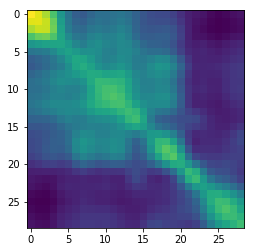

In [27]:
# generate SNF images for each gesture

snf_lst = []
c = 0 # unique id for each image
for n, a in enumerate(arrays):
    if n % 100 == 0: print(n)
    snf = SNF(a, k=0.2, metric=cumulated_euc_ts)
    # calculate graph weights to find knn
    snf.calc_weights()
    snf.normalize_weights()
    # generate and normalize knn graphs
    snf.calc_knn_weights()
    snf.normalize_knn_weights()
    # fuse graphs
    snf.network_fusion(eta=1, iters=20)
    # save template to dict
    smth_snf = gaussian_filter(snf.fused_similarity_template, sigma=1)
    fp = "./Data/"+str(gest_lab[n])+"/"+str(c)+".png"
    plt.imshow(smth_snf)
    plt.savefig(fp)
    c += 1